# Алгоритм Диница

В данной работе представлена задача о максимальном потоке и алгоритм Диница.

## Формальное определение задачи о максимальном потоке

Дана сеть <strong>$N = (V, E)$</strong> с источником $s \in V$, стоком $t \in V$ и пропускными способностями $c$. Величиной потока называется сумма потоков из источника, которая равна сумме потоков в сток $|f| = \sum_\limits{v \in V}f_{sv} = \sum_\limits{w \in V} f(w, t)$.

<strong>Задача о максимальном потоке</strong> заключается в нахождении такого потока, где величина потока максимальна.

## Мотивация

Допустим, что вы хотите отправить своему другу некоторые данные как можно скорее, но единственный способ связи между вами - через одноранговую сеть. Особенностью данной сети является то, что она позволяет вам отправлять данные по указанным вами путям с определёнными ограничениями на размеры данных в секунду, которые вы можете отправлять между парой узлов в этой сети.

In [1]:
from copy import deepcopy
from collections import deque

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

(-1.4, 1.4, -0.64435, 1.13435)

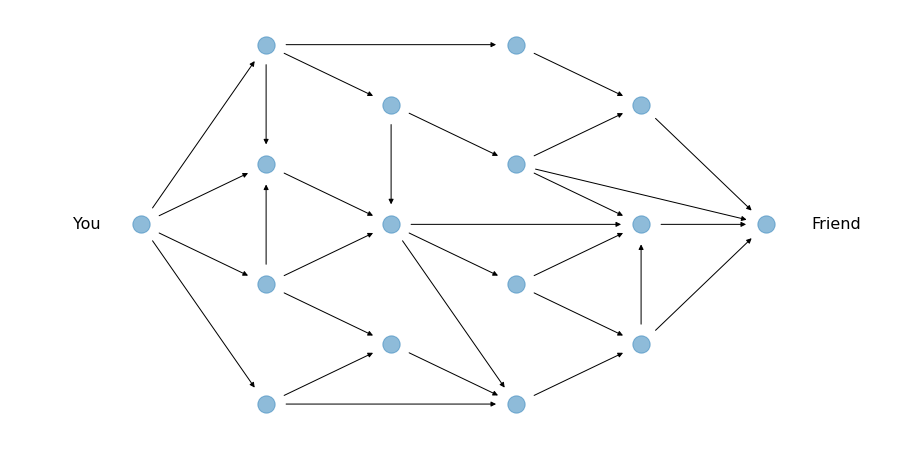

In [2]:
graph = nx.read_gml('data/example_graph.gml')
pos = {k: np.asarray(v) for k, v in graph.nodes(data="pos")}
label_pos = deepcopy(pos)
label_pos["s"][0] = -1.15
label_pos["t"][0] = 1.20
labels = {"s": "You", "t": "Friend"}

fig, ax = plt.subplots(figsize=(16, 8))
nx.draw_networkx_nodes(graph, pos=pos, alpha=0.5)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, min_source_margin=20, min_target_margin=20)
nx.draw_networkx_labels(graph, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4])
ax.axis("off")

Данную проблему можно сформулировать в терминах теории графов.
Пусть $N = (V, E)$ - это одноранговая сеть с набором узлов $V$, которые представляют собой компьютеры, а набор рёбер $E$ показаывает, есть соединение между эти компьютерами. В данном графе есть 2 особых узла - вы и ваш друг. В графе эти вершины представляют собой источник (<em>source</em>) и сток (<em>target</em>) соответственно.

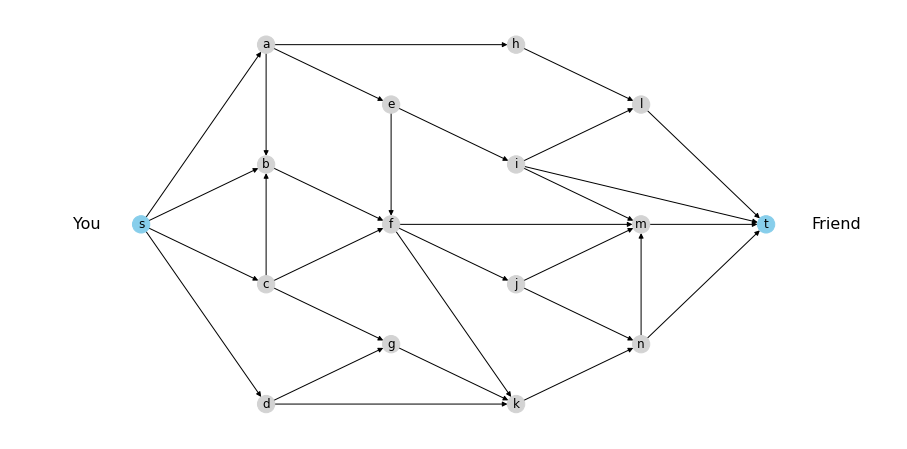

In [3]:
fig, ax = plt.subplots(figsize=(16, 8))

node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in graph.nodes]

nx.draw(graph, pos, ax=ax, node_color=node_colors, with_labels=True)
nx.draw_networkx_labels(graph, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4]);

Теперь представим, что некоторый узел $u$ и узел $v$ подключены. Максимальные данные в секнду, которые вы можете отправить с узла $u$ к узлу $v$ является некоторая величина $c_{uv}$, которая называется <em>пропускной способностью ребра $uv$</em>.

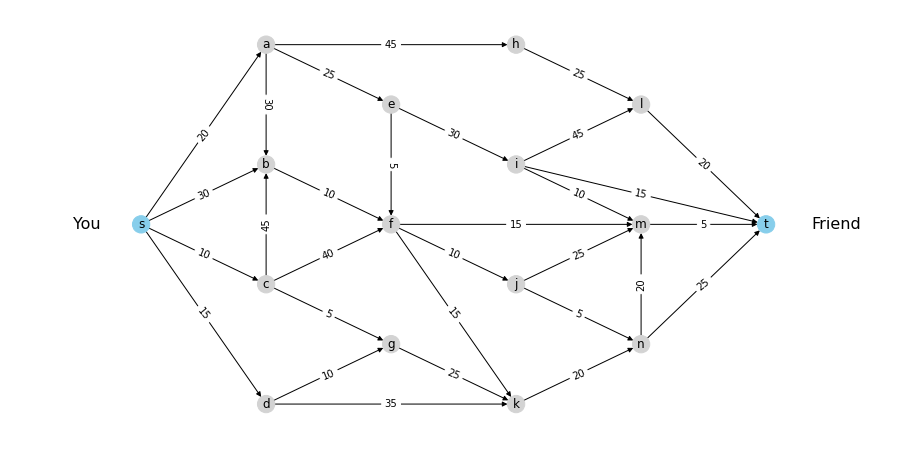

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))

capacities = {(u, v): c for u, v, c in graph.edges(data="capacity")}

nx.draw(graph, pos, ax=ax, node_color=node_colors, with_labels=True)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=capacities, ax=ax)
nx.draw_networkx_labels(graph, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4]);

Прежде чем приступить к планированию путей, необходимо каким-то образом представить отправку пакетов данных в сети. Ясно, что любые переходы между узлами будут нагружать рёбра между ними, поэтому можно представить план значениями пропускной способности, занимаемой им для каждого ребра, который мы назовём <em>потоком</em>.
Формально, поток определяется как $f: E \rightarrow R$, то есть отображение из рёбер $E$ к действительным числам, обозначающим, что сы отправляем данные со скоростью $f(uv)$ через ребро $uv \in E$.
Для того, чтобы план был допустимым, он должен удовлетворять следующим ограничениям:
- <strong>Ограничение пропускной способности</strong>: скорость передачи данных, которые мы отправляем данные с любого узла, не должна превышать его пропускную способность 
$f_{uv} \leq c_{uv}$;
- <strong>Сохранение потока</strong>: скорость, с которой данные отправляются на узел, такая же, как и скорость, с которой узел отправляет данные на другие узлы, за исключением источника и стока
$\sum\limits_{u|(u,v) \in E}f_{uv} = \sum\limits_{w|(v,w) \in E}f_{vw}$ для любого $v \in V \backslash \{s,t\}$

In [5]:
def check_valid_flow(graph, flow, source_node, target_node):
    h = nx.DiGraph()
    h.add_edges_from(flow.keys())

    for (u, v), f in flow.items():
        capacity = graph[u][v]["capacity"]
        h[u][v]["label"] = f"{f}/{capacity}"
        # Capacity constraint
        if f > graph[u][v]["capacity"]:
            h[u][v]["edgecolor"] = "red"
            print(f"Invalid flow: capacity constraint violated for edge ({u!r}, {v!r})")
        # Conservation of flow
        if v not in {source_node, target_node}:
            incoming_flow = sum(flow[(i, v)] if (i, v) in flow else 0 for i in graph.predecessors(v))
            outgoing_flow = sum(flow[(v, o)] if (v, o) in flow else 0 for o in graph.successors(v))
            if not np.math.isclose(incoming_flow, outgoing_flow):
                print(f"Invalid flow: flow conservation violated at node {v}")
                h.nodes[v]["color"] = "red"
    return h


def visualize_flow(flow_graph):
    fig, ax = plt.subplots(figsize=(15, 9))
    nx.draw(graph, pos, ax=ax, node_color=node_colors, edge_color="lightgrey", with_labels=True)
    flow_nc = ["skyblue" 
               if n in {"s", "t"} 
               else flow_graph.nodes[n].get("color", "lightgrey") 
               for n in flow_graph]
    flow_ec = [flow_graph[u][v].get("edgecolor", "black") for u, v in flow_graph.edges]
    edge_labels = {(u, v): lbl for u, v, lbl in flow_graph.edges(data="label")}
    nx.draw(flow_graph, pos, ax=ax, node_color=flow_nc, edge_color=flow_ec)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax);

Пример допустимого потока:

In [6]:
example_flow = {
    ("s", "a"): 20,
    ("a", "e"): 15,
    ("e", "i"): 15,
    ("i", "t"): 15,
    ("a", "h"): 5,
    ("h", "l"): 5,
    ("l", "t"): 5,
}

flow_graph = check_valid_flow(graph, example_flow, "s", "t")

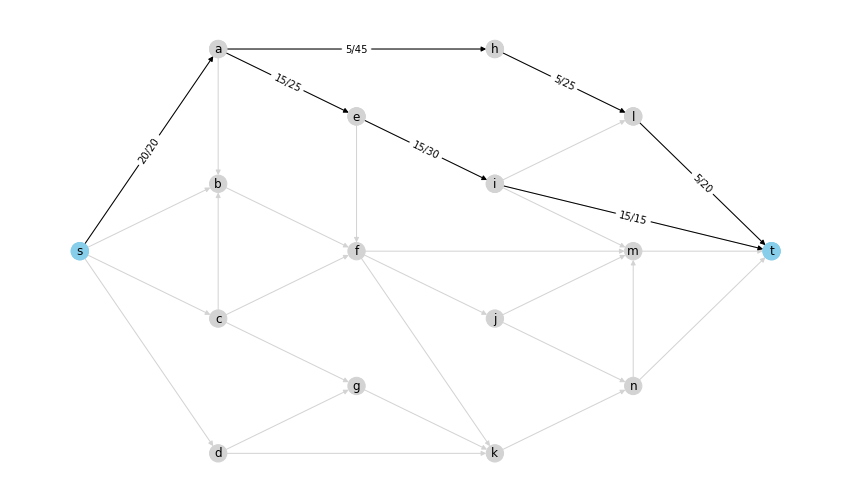

In [7]:
visualize_flow(flow_graph)

Пример недопустимого потока:

In [8]:
example_flow = {
    ("s", "a"): 30,
    ("a", "e"): 25,
    ("e", "i"): 15,
    ("i", "t"): 15,
    ("a", "h"): 5,
    ("h", "l"): 5,
    ("l", "t"): 5,
}

flow_graph = check_valid_flow(graph, example_flow, "s", "t")

Invalid flow: capacity constraint violated for edge ('s', 'a')
Invalid flow: flow conservation violated at node e


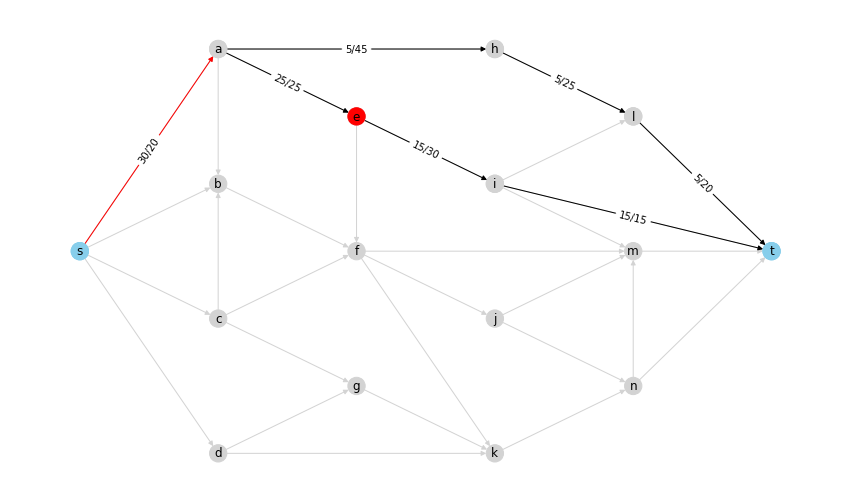

In [9]:
visualize_flow(flow_graph)

Рёбра красного цвета не удовлетворяют ограничениям пропускной способности, а узлы красного цвета не удовлетворяют закону сохранения потока

С какой скоростью мы будем отправлять данные?
Заметим, что любые данные, которые получает узел <em>t</em>, будет получать от своих соседей, следовательно, если просуммировать скорости передачи данных от соседей к узлу-приёмнику, то мы получим скорость передачи данных, при которой <em>t</em> будет получать данные. Или формально:
$|f| = \sum\limits_{u|(u,t) \in E}f_{ut}$.
Так как поток не меняется со временем, то $|f|$ также будет равно $\sum\limits_{u|(s,u) \in E}f_{su}$.

Цель задачи состоит в том, чтобы максимизировать скорость передачи данных, что равносильно максимизации $|f|$.

Итак, мы определили задачу максимального потока.

## Алгоритм Диница

Прежде чем понять, как работает алгоритм Диница, необходимо определиться с некоторыми терминами.

### Остаточная ёмкость и остаточный граф

Если мы отправим поток $f_{uv}$ через ребро $uv$ с пропускной способностью $c_{uv}$, то определим остаточную ёмкость как $g_{uv} = c_{uv} - f_{uv}$, а остаточный граф $N'$ как граф, которая имеет те же рёбра, что и $N$, но без тех рёбер, у которых нулевая остаточная ёмкость.

In [10]:
def residual_graph(graph, flow):
    h = graph.copy()
    for (u, v), f in flow.items():
        capacity = graph[u][v]["capacity"]
        if f > graph[u][v]["capacity"]:
            raise ValueError(f"Flow {f} exceeds the capacity of edge {u!r}->{v!r}.")
        h[u][v]["capacity"] -= f
        if h.has_edge(v, u):
            h[v][u]["capacity"] += f
        else:
            h.add_edge(v, u, capacity=f, etype="rev")
    return h


def draw_residual_graph(residual_graph, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 9))
        ax.axis("off")

    nx.draw_networkx_nodes(residual_graph, pos, node_color=node_colors)
    nx.draw_networkx_labels(residual_graph, pos)

    orig_edges, zero_edges, rev_edges = [], [], []
    for u, v, data in residual_graph.edges(data=True):
        if data.get("etype") == "rev":
            rev_edges.append((u, v))
        elif data["capacity"] == 0:
            zero_edges.append((u, v))
        else:
            orig_edges.append((u, v))

    nx.draw_networkx_edges(residual_graph, pos, edgelist=orig_edges)
    nx.draw_networkx_edges(residual_graph,
                           pos,
                           edgelist=rev_edges,
                           edge_color="goldenrod",
                           connectionstyle="arc3,rad=0.2",)
    nx.draw_networkx_edges(residual_graph,
                           pos, 
                           edgelist=zero_edges,
                           style="--",
                           edge_color="lightgrey")

    rv = set(rev_edges)
    fwd_caps = {(u, v): c 
                for u, v, c in residual_graph.edges(data="capacity") 
                if (u, v) not in rv}
    rev_caps = {(u, v): c 
                for u, v, c in residual_graph.edges(data="capacity") 
                if (u, v) in rv}
    nx.draw_networkx_edge_labels(residual_graph,
                                 pos,
                                 edge_labels=fwd_caps,
                                 label_pos=0.667)
    nx.draw_networkx_edge_labels(residual_graph,
                                 pos,
                                 edge_labels=rev_caps,
                                 label_pos=0.667,
                                 font_color="goldenrod")

Пример:

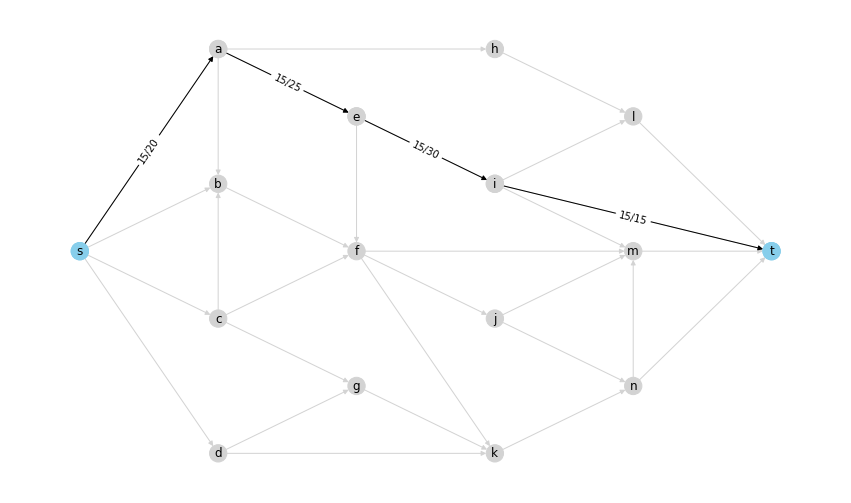

In [11]:
example_flow = {
    ("s", "a"): 15,
    ("a", "e"): 15,
    ("e", "i"): 15,
    ("i", "t"): 15,
}

visualize_flow(check_valid_flow(graph, example_flow, "s", "t"))

Тогда остаточная сеть для данного потока:

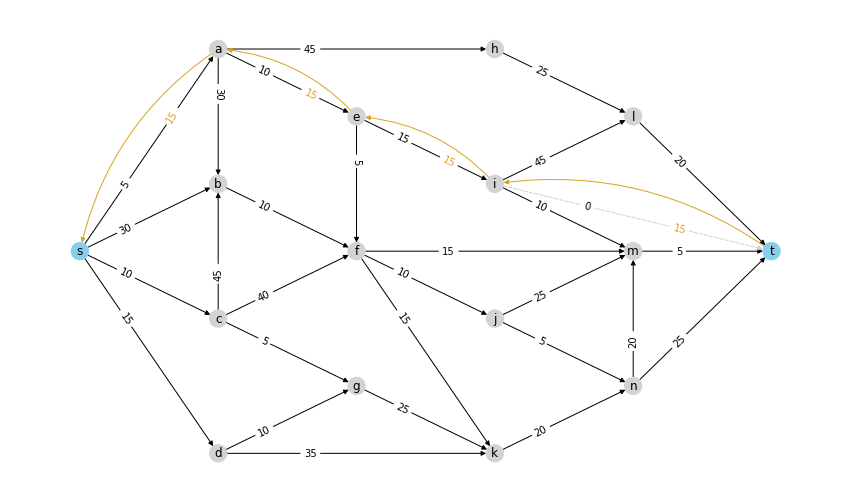

In [12]:
res_graph = residual_graph(graph, example_flow)
draw_residual_graph(res_graph)

В остаточной сети рассматриваются рёбра как $uv$ так и $vu$, если какой-либо из них есть в исходном графе $N$.

### Уровневая сеть (Level Network)

Уровневая сеть - это подграф остаточной сети, который получается после применения алгоритма Поиска в ширину из исходного узла $s$, рассматривая только рёбра, для которых $c_{uv} - f_{uv} > 0$ в остаточной сети.

In [13]:
level_colors = {
    1: "aqua",
    2: "lightgreen",
    3: "yellow",
    4: "orange",
    5: "lightpink",
    6: "violet",
}


def level_bfs(res_graph, flow, source_node, target_node):
    parents, level = {}, {}
    queue = deque([source_node])
    level[source_node] = 0
    while queue:
        if target_node in parents:
            break
        u = queue.popleft()
        for v in res_graph.successors(u):
            if (v not in parents) and (res_graph[u][v]["capacity"] > 0):
                parents[v] = u
                level[v] = level[u] + 1
                queue.append(v)
    return parents, level


def draw_level_network(res_graph, parents, level, background=False):
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")

    # Draw nodes
    nodelist = list(level.keys())
    if background:
        level_nc = "lightgrey"
    else:
        level_nc = [level_colors[l] for l in level.values()]
        level_nc[0] = level_nc[-1] = "skyblue"
    nx.draw_networkx_nodes(res_graph,
                           pos,
                           nodelist=nodelist,
                           node_color=level_nc)
    if not background:
        nx.draw_networkx_labels(res_graph, pos)

    fwd_edges = [(v, u) for u, v in parents.items() if (v, u) in graph.edges]
    labels = {(u, v): res_graph[u][v]["capacity"] for u, v in fwd_edges}
    ec = "lightgrey" if background else "black"
    nx.draw_networkx_edges(res_graph,
                           pos,
                           edgelist=fwd_edges,
                           edge_color=ec)
    if not background:
        nx.draw_networkx_edge_labels(res_graph,
                                     pos,
                                     edge_labels=labels,
                                     label_pos=0.667)

    rev_edges = [(v, u) for u, v in parents.items() if (v, u) not in graph.edges]
    labels = {(u, v): res_graph[u][v]["capacity"] for u, v in rev_edges}
    ec = "lightgrey" if background else "goldenrod"
    nx.draw_networkx_edges(res_graph,
                           pos,
                           edgelist=rev_edges,
                           connectionstyle="arc3,rad=0.2",
                           edge_color=ec)
    if not background:
        nx.draw_networkx_edge_labels(res_graph,
                                     pos,
                                     edge_labels=labels,
                                     label_pos=0.667,
                                     font_color="goldenrod")

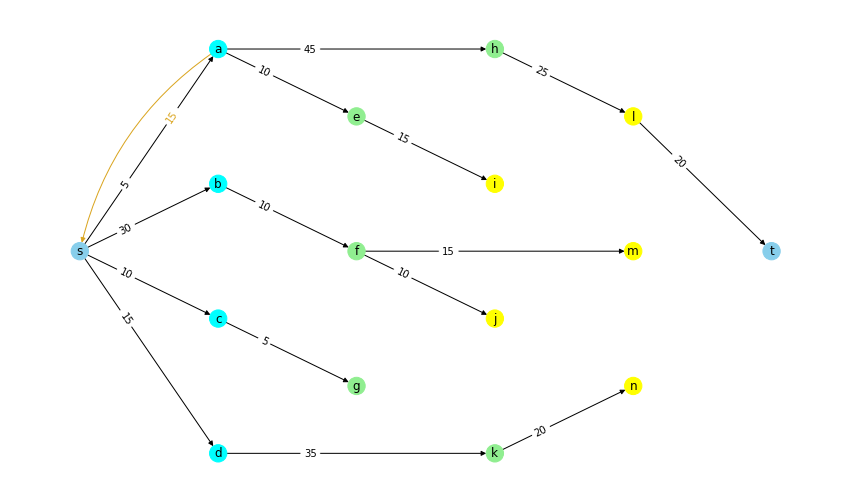

In [14]:
parents, level = level_bfs(res_graph, example_flow, "s", "t")
draw_level_network(res_graph, parents, level)

Важно, что если узел стока $t$ недоступен из исходного узла $s$, то через остаточную сеть больше нельзя пропустить поток.

### Дополняющие пути и потоки

Дополняющий путь $P$ - это путь от исходного узла $s$ в узел $t$ такой, что все рёбра на пути имеют положительную остаточную пропускную способность, то есть $g_{uv}>0$ для любого ребря $uv \in P$. Дополняющий поток $\alpha$ для пути $P$ - минимальное значение остаточного потока по всем рёбрам $P$, то есть $\alpha = min\{g_{uv}, uv \in P\}$.

Увеличить поток вдоль пути $P$ означает уменьшить остаточночные пропускные способности рёбер в пути $P$ так, чтобы оставить хотя бы одно ребро в остаточной ссети с нулевой пропускной способностью.

Дополняющий путь находится с помощью алгоритма Поиска в глубину.

In [15]:
def aug_path_dfs(parents, flow, source_node, target_node):
    path = []
    u = target_node
    f = 3 * max(flow.values())
    while u != source_node:
        path.append(u)
        v = parents[u]
        f = min(f, res_graph.pred[u][v]["capacity"] - flow.get((u, v), 0))
        u = v
    path.append(source_node)
    
    return path, f

Дополняющий путь до "дополнения":

{('l', 't'): Text(0.718536, 0.5718300000000001, '20'),
 ('h', 'l'): Text(0.326536, 0.898415, '25'),
 ('a', 'h'): Text(-0.326928, 0.98, '45'),
 ('s', 'a'): Text(-0.849464, 0.48975499999999994, '5')}

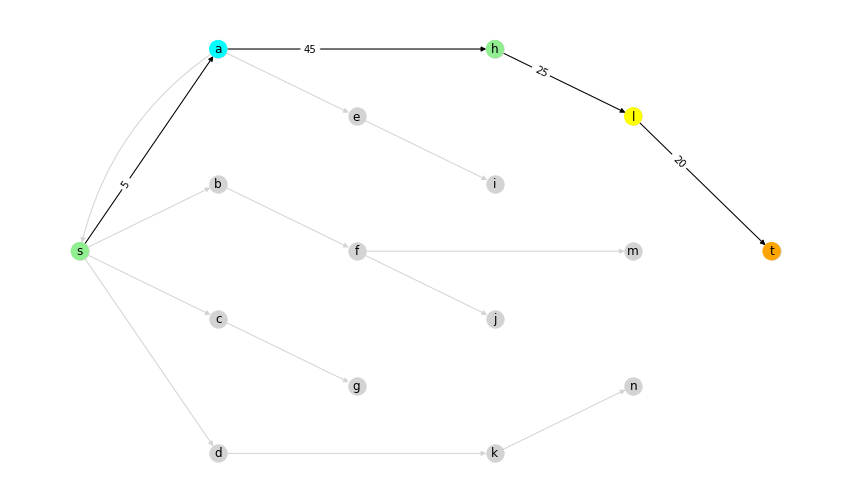

In [16]:
path, min_resid_flow = aug_path_dfs(parents, example_flow, "s", "t")

# Visualization
draw_level_network(res_graph, parents, level, background=True)
nc = [level_colors[level[n]] for n in path]
el = [(v, u) for u, v in nx.utils.pairwise(path)]
nx.draw(res_graph, pos, nodelist=path, edgelist=el, node_color=nc, with_labels=True)
edgelabels = {(u, v): res_graph[u][v]["capacity"] for u, v in el}
nx.draw_networkx_edge_labels(res_graph, pos, edge_labels=edgelabels, label_pos=0.667)

Дополняющий путь после:

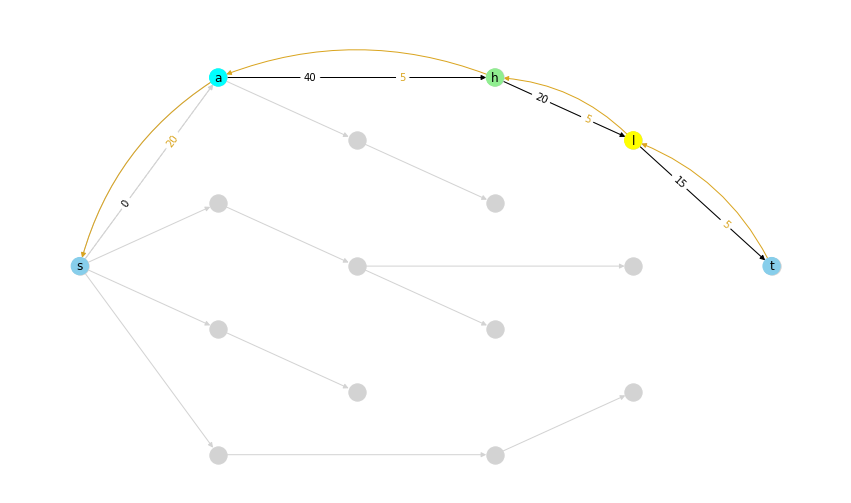

In [17]:
aug_flow = {(v, u): min_resid_flow for u, v in nx.utils.pairwise(path)}

draw_level_network(res_graph, parents, level, background=True)
aug_path = residual_graph(res_graph.subgraph(path), aug_flow)

nodes = list(aug_path.nodes)
node_colors = [level_colors[level[n]] for n in nodes]
node_colors[nodes.index("s")] = node_colors[nodes.index("t")] = "skyblue"

draw_residual_graph(aug_path, ax=plt.gca())

Конечная остаточная сеть:

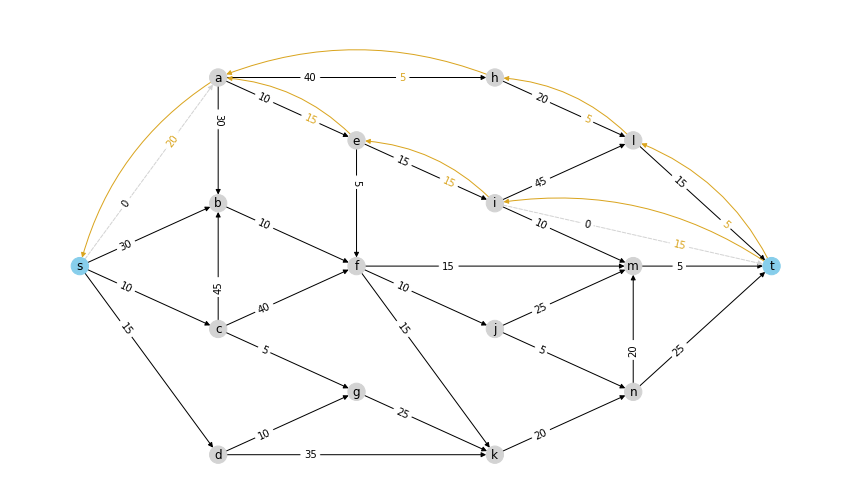

In [18]:
R = residual_graph(res_graph, aug_flow)

# Original color scheme for residual graph
node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in R.nodes]
draw_residual_graph(R)

Каждый из перечисленных шагов играет важную роль в алгоритме Диница для нахождения максимального потока в сети, кратко изложенном ниже:

1. Инициализировать поток с нулевым значением, $f_{uv}=0$;
1. Построить остаточную сеть $N'$ из этого потока;
1. Найти уровневую сеть с помощью алгоритма Поиска в ширину и если $t$ не находится в этой сети, то выводим поток;
1. Найти дополняющий путь $P$ в уровневой сети;
1. Дополнить поток по рёбрам пути $P$, что даст новую остаточную сеть;
1. Повторить с пункта 3 с полученной остаточной сетью.

## Поиск максимального потока

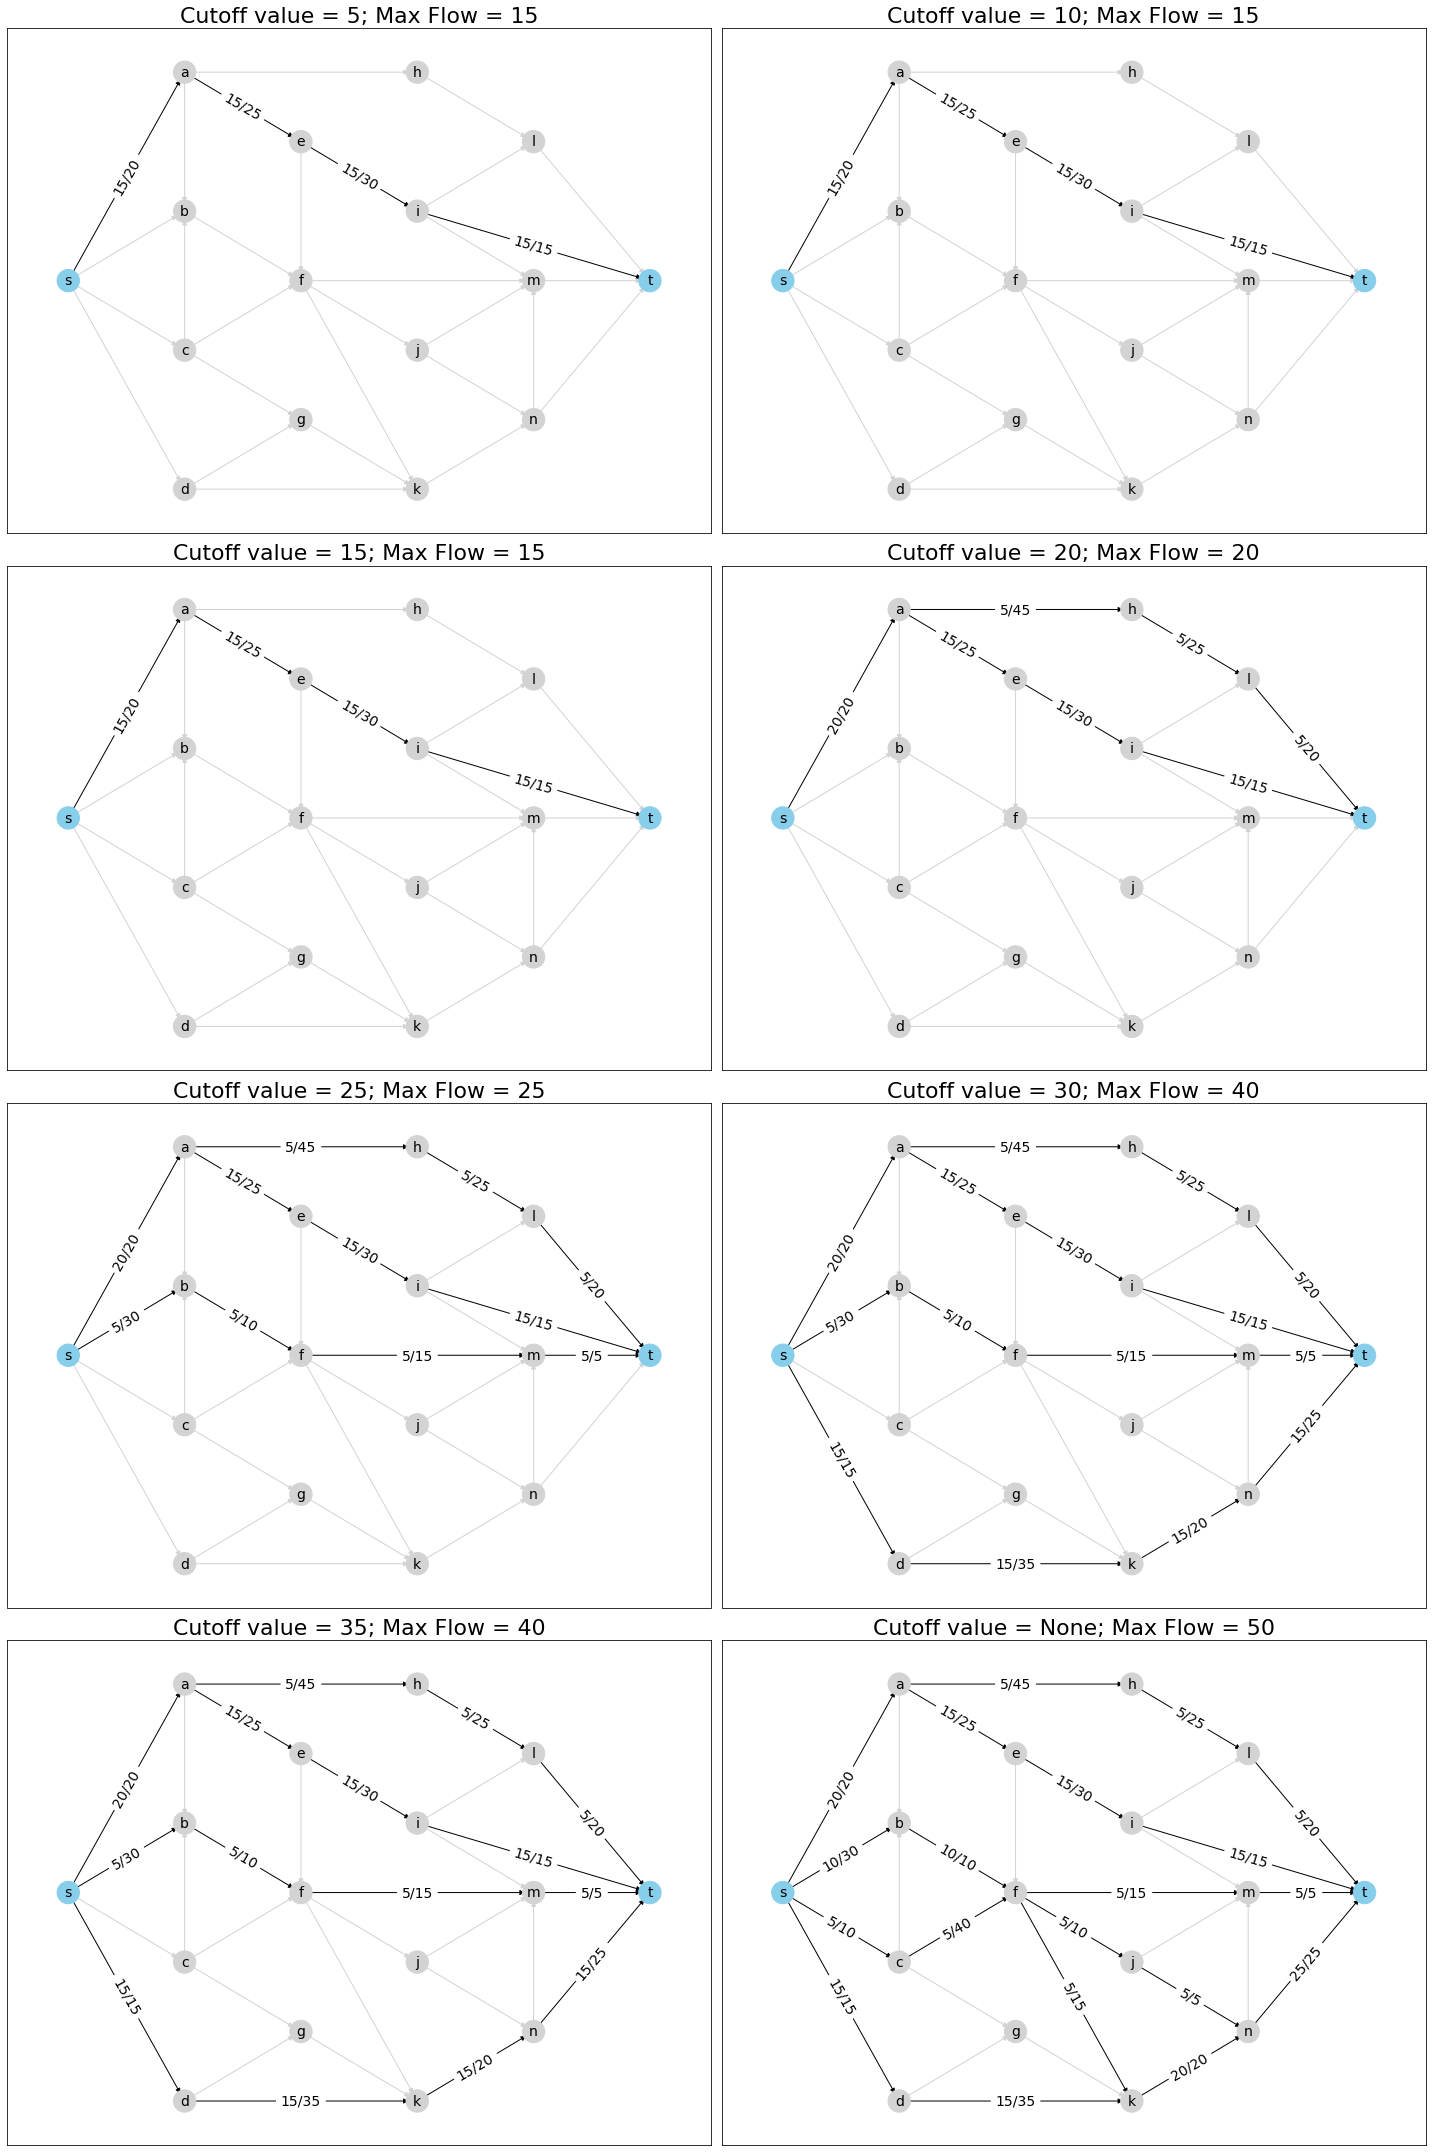

In [19]:
cutoff_list = [5, 10, 15, 20, 25, 30, 35, None]

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in graph.nodes]

for cutoff, ax in zip(cutoff_list, axes.ravel()):
    res_graph = nx.flow.dinitz(graph, s="s", t="t", capacity="capacity", cutoff=cutoff)
    edge_colors = ["lightgray" if res_graph[u][v]["flow"] == 0 else "black" for u, v in graph.edges]
    edge_labels = {(u, v): f"{res_graph[u][v]['flow']}/{graph[u][v]['capacity']}"
                   for u, v in graph.edges
                   if res_graph[u][v]["flow"] != 0}

    nx.draw_networkx_nodes(graph, 
                           pos=pos,
                           ax=ax,
                           node_size=500,
                           node_color=node_colors)
    nx.draw_networkx_labels(graph,
                            pos=pos,
                            ax=ax,
                            font_size=14)
    nx.draw_networkx_edges(graph,
                           pos=pos,
                           ax=ax,
                           edge_color=edge_colors)
    nx.draw_networkx_edge_labels(graph,
                                 pos=pos,
                                 ax=ax,
                                 edge_labels=edge_labels, 
                                 font_size=14)
    ax.set_title(f"Cutoff value = {cutoff}; Max Flow = {res_graph.graph['flow_value']}",
                 size=22,)

fig.tight_layout()